##Markdown

In [52]:
# Dependencies and calls
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as scp

In [35]:
# Set data CSVs as path variables, call path as read_csv
mouse_csv = "Resources/Mouse_metadata.csv"
mouse_id_df = pd.read_csv(mouse_csv) 
study_csv = "Resources/Study_results.csv"
study_results_df = pd.read_csv(study_csv)

In [36]:
mouse_id_df.columns

Index(['Mouse ID', 'Drug Regimen', 'Sex', 'Age_months', 'Weight (g)'], dtype='object')

In [37]:
study_results_df.columns

Index(['Mouse ID', 'Timepoint', 'Tumor Volume (mm3)', 'Metastatic Sites'], dtype='object')

In [38]:
# Combine df using outer first just so we can see what columns are missing data for each ID row, if any
mouse_study_df = pd.merge(study_results_df,mouse_id_df,how = "outer", on = ["Mouse ID", "Mouse ID"])

# subset the combined data frame to show any NaN rows, any(axis = 1) is tagging any rows that satisfy the condition of isna() in each column
# subsets any rows that have missing data in any column
mouse_study_nan_rows = mouse_study_df[mouse_study_df.isna().any(axis = 1)]
mouse_study_nan_rows.head()

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)


In [39]:
# Confirm number of mice in study using pd.nunique
mouse_study_df["Mouse ID"].nunique()

249

In [40]:
#subset mouse_study_df looking for duplicate timepoints under each mouse id, pd.unique hierarchy subsetting
mouse_study_time_duplicates = mouse_study_df.loc[mouse_study_df.duplicated(subset = ["Mouse ID","Timepoint"]),"Mouse ID"].unique()
mouse_study_time_duplicates

array(['g989'], dtype=object)

In [41]:
# lets look at all the mouse data associated with g989
mouse_study_df[mouse_study_df["Mouse ID"] == "g989"]

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
860,g989,0,45.000000,0,Propriva,Female,21,26
861,g989,0,45.000000,0,Propriva,Female,21,26
862,g989,5,48.786801,0,Propriva,Female,21,26
863,g989,5,47.570392,0,Propriva,Female,21,26
864,g989,10,51.745156,0,Propriva,Female,21,26
865,g989,10,49.880528,0,Propriva,Female,21,26
866,g989,15,51.325852,1,Propriva,Female,21,26
867,g989,15,53.442020,0,Propriva,Female,21,26
868,g989,20,55.326122,1,Propriva,Female,21,26
869,g989,20,54.657650,1,Propriva,Female,21,26


In [42]:
# now we create a clean df that does not include any g989 tomfoolery, using the duplicate rep df so that I can scale this to other data sets if needed
clean_mouse_study_df = mouse_study_df[mouse_study_df["Mouse ID"].isin(mouse_study_time_duplicates) == False]
# checking number of uniques in clean df, we should be down 1
clean_mouse_study_df["Mouse ID"].nunique()

248

In [51]:
# using agg to apply summary table, agg being fed dictionary using tumor volume as key(s), repeated for each stat
drug_group_summary = clean_mouse_study_df.groupby(['Drug Regimen']).agg({'Tumor Volume (mm3)':['mean','median','var','std','sem']})
drug_group_summary

Tumor Volume (mm3)                                          
                           mean     median        var       std       sem
Drug Regimen                                                             
Capomulin             40.675741  41.557809  24.947764  4.994774  0.329346
Ceftamin              52.591172  51.776157  39.290177  6.268188  0.469821
Infubinol             52.884795  51.820584  43.128684  6.567243  0.492236
Ketapril              55.235638  53.698743  68.553577  8.279709  0.603860
Naftisol              54.331565  52.509285  66.173479  8.134708  0.596466
Placebo               54.033581  52.288934  61.168083  7.821003  0.581331
Propriva              52.320930  50.446266  43.852013  6.622085  0.544332
Ramicane              40.216745  40.673236  23.486704  4.846308  0.320955
Stelasyn              54.233149  52.431737  59.450562  7.710419  0.573111
Zoniferol             53.236507  51.818479  48.533355  6.966589  0.516398

<Axes: title={'center': 'Obervations Counts'}, xlabel='Drug Regiment', ylabel='# of Mouse-Timepoint Observations'>

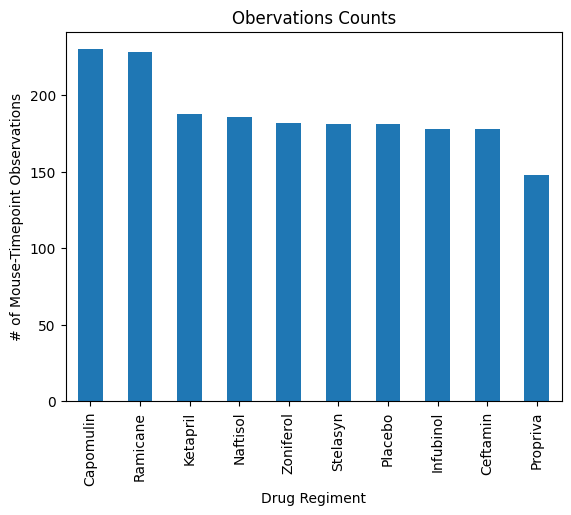

In [62]:
# pub crawl and then Shari's (Bar and Pie charts)
# Bar plot showing number of observations per drug run
observations = clean_mouse_study_df["Drug Regimen"].value_counts()
observations.plot(x = observations.index,
                  y = observations.count,
                  kind = "bar",
                  xlabel = "Drug Regiment",
                  ylabel = "# of Mouse-Timepoint Observations",
                  title = "Obervations Counts")
